In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import torch

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

from src.dataloaders import FPathDataset, FPathLazyDataset
from src.preprocesses import VTFPreprocessor, InfodrawPreprocessor, TargetPreprocessor, ImagePreprocessor
from train2 import FCModel, CNNModel, ResCNN1DLayer, FPathDataset

In [2]:
vtf_path        = "dataset\\test\\vtfs\\color_901_fpath_of_infodraw.npz"
infodraw_path   = "dataset\\test\\infodraws\\color_901_out.png"
target_path     = "dataset\\test\\targets\\line_901.png"
fpath_path      = "dataset\\test\\fpaths\\color_901_fpath.npz"
img_path        = "dataset\\test\\imgs\\color_901.png"

vtf         = VTFPreprocessor.get(vtf_path)
infodraw    = InfodrawPreprocessor.get(infodraw_path)
target      = TargetPreprocessor.get(target_path)
fpath       = np.load(fpath_path)['data'] 
img         = ImagePreprocessor.get(img_path)

In [3]:
def draw_gray_img(img):
    plt.figure(figsize=(10.24, 10.24))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
def draw_img(img):
    plt.figure(figsize=(10.24, 4*10.24))
    plt.imshow(img)
    plt.axis('off')

In [4]:
def save_vtf_gif(vtf):
    from IPython.display import Image as Img
    from IPython.display import display
    
    infodraw = Image.fromarray(vtf[10] * 255)
    infodraw.save("out.gif", save_all=True, append_images=[Image.fromarray(vtf[i] * 255) for i in range(21)], loop=0xff, duration=500)

In [5]:
save_vtf_gif(vtf)

In [17]:
model = torch.load("weights\\best_CNNModel_acc78.31.pth")

model = model.to('cpu')
model = model.eval()

vtf_tensor = torch.tensor(vtf).unsqueeze(0)
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)

_, _, H, W = infodraw_tensor.shape

print(f"vtf_tensor: {vtf_tensor.shape}, infodraw_tensor: {infodraw_tensor.shape}")

"""
    pred \ target | sketch  non-sketch
    ===================================
    sketch        |  0,0        0,1      
    non-sketch    |  1,0        1,1
"""
confusion_mat = np.zeros((2, 2))
cnt_candidates = 0

result = infodraw_tensor.clone()
for h in tqdm(range(H)):
    for w in range(W):
        if infodraw_tensor[0, 0, h, w] < 0.99:
            selected_vtf = vtf_tensor[0, :, h, w]
            
            pred = model(selected_vtf.unsqueeze(0))
            pred = 1.0 if pred > 0.5 else 0.0
            
            result[0, 0, h, w] = pred
            
            gt = target[0, h, w]
            
            cnt_candidates += 1
            confusion_mat[int(pred), int(gt)] += 1

C:\Users\Joono\AppData\Local\Temp\ipykernel_6664\1011182490.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)


vtf_tensor: torch.Size([1, 21, 1024, 1024]), infodraw_tensor: torch.Size([1, 1, 1024, 1024])


  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [00:59<00:00, 17.32it/s]


In [18]:
print(cnt_candidates)
print(confusion_mat)

57741
[[ 7804.  3201.]
 [ 7431. 39305.]]


In [20]:
sketch_precision = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
sketch_recall = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[1, 0])
sketch_f1score = 2 * (sketch_precision * sketch_recall) / (sketch_precision + sketch_recall)
sketch_f1score

0.5948170731707317

In [22]:
non_sketch_precision = confusion_mat[1, 1] / (confusion_mat[1, 1] + confusion_mat[0, 1])
non_sketch_recall = confusion_mat[1, 1] / (confusion_mat[1, 1] + confusion_mat[1, 0])
non_sketch_f1score = 2 * (non_sketch_precision * non_sketch_recall) / (non_sketch_precision + non_sketch_recall)
non_sketch_f1score

0.8808632706573138

1000


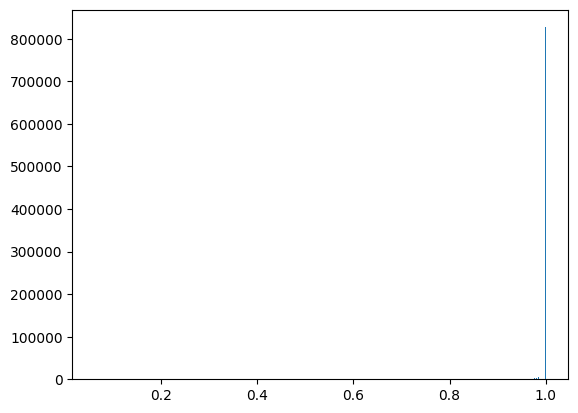

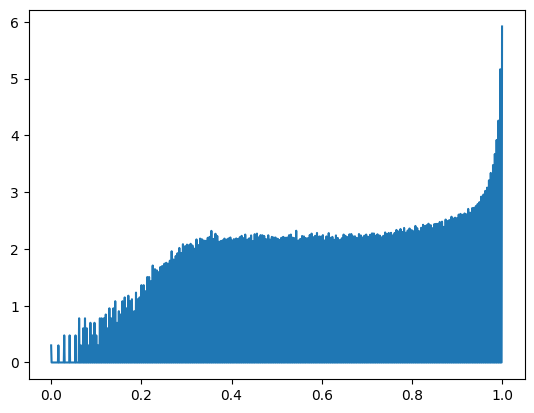

In [45]:
hist = plt.hist(infodraw.flatten(), bins=1000)

plt.figure()

print(len(hist[0]))

plt.plot(np.linspace(0, 1, 1000), np.log10(hist[0]+1))

(21, 1024, 1024) torch.Size([1, 1024, 1024]) torch.Size([1, 1024, 1024])


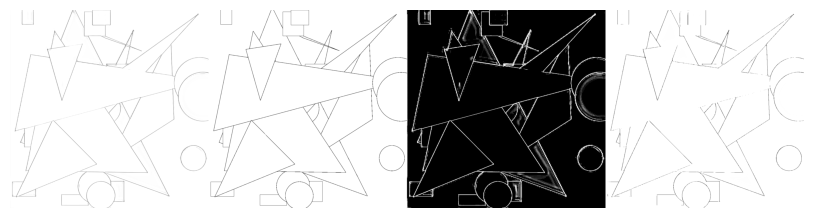

In [7]:
print(vtf.shape, infodraw.shape, target.shape)
draw_gray_img(np.concatenate([infodraw[0], target[0], (infodraw[0] < 0.99).float(), result.squeeze().detach().cpu().numpy()], axis=1))

In [8]:
infodraw_img    = np.array(infodraw[0]) * 255
target_img      = np.array(target[0]) * 255
noise_img       = np.array((infodraw[0] < 0.99).float()) * 255
result_img      = result.squeeze().detach().cpu().numpy() * 255
img_img         = np.array(img).transpose((1, 2, 0)) * 255

cv2.imwrite("infodraw.png", infodraw_img)
cv2.imwrite("target.png", target_img)
cv2.imwrite("noise.png", noise_img)
cv2.imwrite("result.png", result_img)

True

In [9]:
overlap_infodraw_target_img = cv2.addWeighted(infodraw_img, 0.5, target_img, 0.5, 0)
cv2.imwrite("overlap_infodraw_target.png", overlap_infodraw_target_img)

True

In [10]:
rgb_infodraw_img = np.stack([infodraw_img, infodraw_img, infodraw_img], axis=2)
print(rgb_infodraw_img.shape, img_img.shape)

overlap_infodraw_img_img = cv2.addWeighted(rgb_infodraw_img, 0.9, img_img, 0.1, 0)
cv2.imwrite("overlap_infodraw_img.png", overlap_infodraw_img_img)

rgb_target_img = np.stack([target_img, target_img, target_img], axis=2)
overlap_infodraw_img_target_img = cv2.addWeighted(rgb_target_img, 0.9, img_img, 0.1, 0)
cv2.imwrite("overlap_target_img.png", overlap_infodraw_img_target_img)

rgb_result_img = np.stack([result_img, result_img, result_img], axis=2)
overlap_infodraw_img_target_result_img = cv2.addWeighted(rgb_result_img, 0.9, img_img, 0.1, 0)
cv2.imwrite("overlap_result_img.png", overlap_infodraw_img_target_result_img)

(1024, 1024, 3) (1024, 1024, 3)


True

In [11]:
red_infodraw_img = np.stack([infodraw_img, infodraw_img, np.ones_like(infodraw_img)*255], axis=2)
cv2.imwrite("red_infodraw.png", red_infodraw_img)

blue_target_img = np.stack([np.ones_like(infodraw_img)*255, target_img, target_img], axis=2)
cv2.imwrite("blue_target.png", blue_target_img)

green_result_img = np.stack([result_img, np.ones_like(infodraw_img)*255, result_img], axis=2)
cv2.imwrite("green_result.png", green_result_img)

overlap_infodraw_target = cv2.addWeighted(red_infodraw_img, 0.5, blue_target_img, 0.5, 0)
cv2.imwrite("overlap_infodraw_target.png", overlap_infodraw_target)

overlap_infodraw_result = cv2.addWeighted(red_infodraw_img, 0.5, green_result_img, 0.5, 0)
cv2.imwrite("overlap_infodraw_result.png", overlap_infodraw_result)

overlap_target_result = cv2.addWeighted(blue_target_img, 0.5, green_result_img, 0.5, 0)
cv2.imwrite("overlap_target_result.png", overlap_target_result)

True